# Anime Recommendation System
#### Alejandra Avitia-Davila, Crystal Feng, Simon Chau, and Tyler Lafond

In [129]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

animes_df = pd.read_csv("animes.csv")
animes_df = animes_df.drop(columns=['synopsis', 'aired', 'episodes', 'members', 'img_url', 'link']).drop_duplicates()
profiles_df = pd.read_csv("profiles.csv")
profiles_df = profiles_df.drop(columns = ['gender', 'birthday', 'link']).drop_duplicates()
print(animes_df.head())
print(profiles_df.head())
print(len(profiles_df.index))
#profiles_df_2 = profiles_df.head(5)

     uid                             title  \
0  28891           Haikyuu!! Second Season   
1  23273           Shigatsu wa Kimi no Uso   
2  34599                     Made in Abyss   
3   5114  Fullmetal Alchemist: Brotherhood   
4  31758  Kizumonogatari III: Reiketsu-hen   

                                               genre  popularity  ranked  \
0  ['Comedy', 'Sports', 'Drama', 'School', 'Shoun...         141    25.0   
1  ['Drama', 'Music', 'Romance', 'School', 'Shoun...          28    24.0   
2  ['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...          98    23.0   
3  ['Action', 'Military', 'Adventure', 'Comedy', ...           4     1.0   
4   ['Action', 'Mystery', 'Supernatural', 'Vampire']         502    22.0   

   score  
0   8.82  
1   8.83  
2   8.83  
3   9.23  
4   8.83  
           profile                                    favorites_anime
0   DesolatePsyche  ['33352', '25013', '5530', '33674', '1482', '2...
1        baekbeans  ['11061', '31964', '853', '20583', '918'

***Defining functions:***
- genre_list(anime_uid)
- anime_list(profile)

In [147]:
def genre_list(anime_uid):
    if(anime_uid == ""): return []
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return []
    raw_genres = animes_df.loc[animes_df["uid"] == anime_uid]["genre"].array[0]
    genres = raw_genres.strip("][").replace("'", "").split(", ")
    for genre in genres:
        genre = genre.replace(" ", "")
    return genres

#print(genre_list(33352))

def anime_list(profile):
    if(profile > len(profiles_df.index)) : return []
    raw_favorites = profiles_df.iloc[profile]["favorites_anime"]
    favorites = raw_favorites.strip("][").replace("'", "").split(", ")
    for anime in favorites:
        anime = anime.replace("'", "")
    return favorites
    
#print(anime_list(0))

def anime_name(anime_uid):
    if(anime_uid == ""): return ""
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return ""
    return animes_df.loc[animes_df["uid"] == anime_uid]["title"].array[0]

#print(anime_name(28891))

Haikyuu!! Second Season


### Computing frequencies for profiles

In [93]:
#commented out and saved to csv since this process takes a while

#df_profile_freq = pd.DataFrame() #index is same as profile_df_index
#for profile in profiles_df.index:
#    favorites = anime_list(profile)
#    genres = []
#    for anime in favorites:
#        genres += genre_list(anime)
#    genre_series = pd.Series(genres)
#    num_genres = len(genres)
#    genre_frequencies = genre_series.value_counts() / num_genres
#    df_profile_freq = df_profile_freq.append(genre_frequencies, ignore_index=True)
#df_profile_freq = df_profile_freq.drop(columns=[""])
#df_profile_freq = df_profile_freq.fillna(0)
#df_profile_freq.to_csv("profile_genres.csv", index=False)

### PCA Decomposition on profile genre frequencies

In [123]:
df_freq = pd.read_csv("profile_genres.csv")
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df_freq)
print("Explained variation per principal component:", pca.explained_variance_ratio_)
cumulative_variance = sum(pca.explained_variance_ratio_) 
print('Cumulative variance explained by 5 principal components: ', cumulative_variance, "%")

Explained variation per principal component: [0.30673005 0.11921416 0.087338   0.05529435 0.05119795]
Cumulative variance explained by 5 principal components:  0.6197745164444133 %


### Using Elbow Method with WCSS to determine optimal k-value 

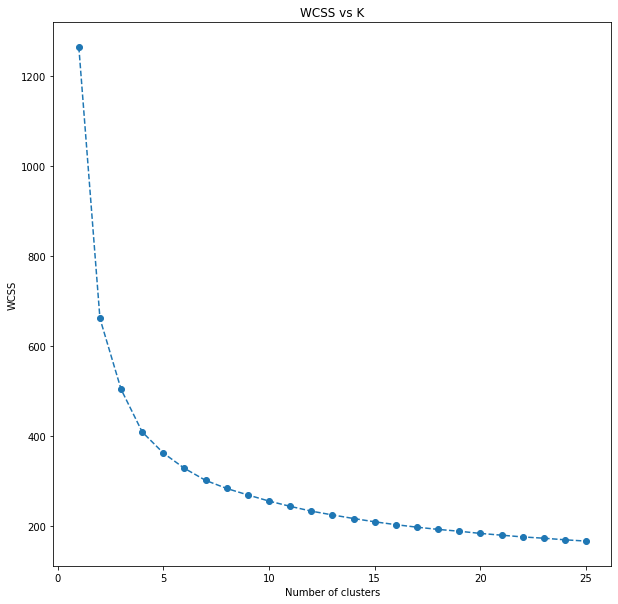

In [132]:
wcss = []
for i in range(1, 26):
    k_means = KMeans(n_clusters=i, init='k-means++', random_state=20)
    k_means.fit(pca_result)
    wcss.append(k_means.inertia_)

    
plt.figure(figsize=(10,10))
plt.plot(range(1,26), wcss, marker="o", linestyle='--')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("WCSS vs K")
plt.show()

In [141]:
optimal_k = 5
final_k_means = KMeans(n_clusters = optimal_k, init = "k-means++", random_state=20)
final_k_means.fit(pca_result)
df_pca_kmeans = pd.concat([profiles_df.reset_index(drop=True), pd.DataFrame(pca_result)], axis=1)
df_pca_kmeans.columns.values[-5:] = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5"]
df_pca_kmeans["Cluster"] = final_k_means.labels_
mapping = {0:'first', 1:"second", 2:"third", 3:"fourth", 4:"fifth"}
df_pca_kmeans["Cluster"] = df_pca_kmeans["Cluster"].map(mapping)

df_freq["Cluster"] = final_k_means.labels_

In [143]:
print(df_pca_kmeans.head())
#print(df_freq.head())

           profile                                    favorites_anime  \
0   DesolatePsyche  ['33352', '25013', '5530', '33674', '1482', '2...   
1        baekbeans  ['11061', '31964', '853', '20583', '918', '925...   
2             skrn  ['918', '2904', '11741', '17074', '23273', '32...   
3     edgewalker00           ['5680', '849', '2904', '3588', '37349']   
4  aManOfCulture99  ['4181', '7791', '9617', '5680', '2167', '4382...   

   Component 1  Component 2  Component 3  Component 4  Component 5 Cluster  
0     0.099536    -0.011276     0.003781    -0.045363     0.013326  second  
1     0.106585     0.022280    -0.053599     0.042944    -0.028786   third  
2     0.084845    -0.009300     0.050995    -0.025231     0.014180  second  
3     0.109047     0.016547    -0.039408     0.057750    -0.029771   third  
4     0.093814    -0.175802    -0.006662     0.030903    -0.051450  fourth  


### Using KNN to classify new user into a cluster
Here we need to:
- implement and train a KNN model with the df_freq data
   - I feel like df_freq should be the data we train on since PCA reduction loses around 40% of our data
- evaluate our KNN model
- compute genre frequencies from a new user's list of animes
- classify new user into a cluster

https://www.freecodecamp.org/news/how-to-build-and-train-k-nearest-neighbors-ml-models-in-python/

### Finding Recommendations 
Here we need to:
- find all users in the same cluster as the new one (possible neighbors)
- compute distances between each data point and the current one
    - https://stackoverflow.com/questions/64374482/how-to-calculate-distance-for-every-row-in-a-pandas-dataframe-from-a-single-poin
- find n-smallest distances with their indices
    - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nsmallest.html
- find a favorites list of profiles at those indices
- remove any entries which are from the new user's favorites list and print the names of those animes